## Yelp Preprocessing & EDA

#### Import Libraries

In [57]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
import nltk
import langid 

from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim.models import Word2Vec

In [58]:
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
porter = nltk.PorterStemmer()

#### Parameter Settings

In [59]:
TOTAL_REVIEW_NUM = 100000
ORIGIN_YELP_PATH = '../data/yelp_academic_dataset_review.json'
ENGLISH_YELP_REVIEW_PATH = '../data/english_yep_reviews.csv'
# word2vec
WORD2VEC_DIMENSION = 200
WORD2VEC_MODEL_PATH = '../data/word2vec_model'
YELP_REVIEW_W2V_PATH = '../data/w2v_yelp.csv'
# bag of words
YELP_REVIEW_BOW_PATH = '../data/bow_yelp.csv'

#### Read Reviews in English

In [60]:
reviews = []
eng_count = 0
non_eng_count = 0
with open(ORIGIN_YELP_PATH, encoding="utf8") as fl:
    for i, line in enumerate(fl):
        content = json.loads(line)
        if langid.classify(content['text'])[0]=='en':
            reviews.append(content)
            eng_count += 1
            if eng_count == TOTAL_REVIEW_NUM:
                break
        else:
            non_eng_count += 1
df_reviews = pd.DataFrame(reviews)
print('readin {} english reviews and dropped {} non-english reviews'.format(eng_count, non_eng_count))
df_reviews.head()

readin 100000 english reviews and dropped 504 non-english reviews


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


### Feature Engineering

In [61]:
# Focus on Stars and Texts Only
df_reviews = df_reviews[["stars", "text"]]
df_reviews.head()

,stars,text
0,2.0,"As someone who has worked with many museums, I..."
1,1.0,I am actually horrified this place is still in...
2,5.0,I love Deagan's. I do. I really do. The atmosp...
3,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,4.0,"Oh happy day, finally have a Canes near my cas..."


In [62]:
# Check if there are any missing values
df_reviews.isna().any()

stars    False
text     False
dtype: bool

Text(0.5, 0, 'Number of Stars')

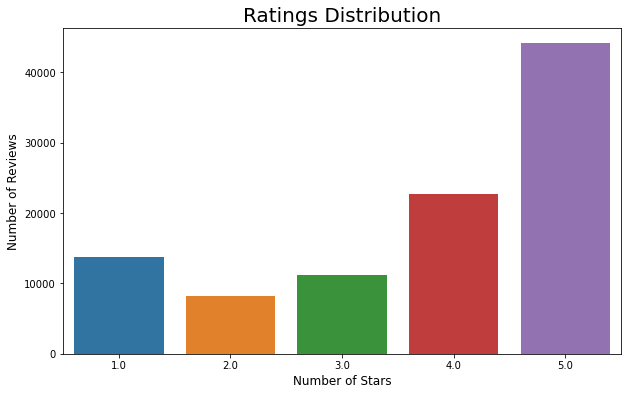

In [63]:
# Check the distribution of Stars
stars_count = df_reviews["stars"].value_counts()
stars_count = stars_count.sort_index()

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(stars_count.index, stars_count.values)
plt.title("Ratings Distribution", fontsize=20)
plt.ylabel("Number of Reviews", fontsize=12)
plt.xlabel("Number of Stars", fontsize=12)

In [64]:
# Categorize Stars into different levels
# 0 (Negative)=> 1 star or 2 stars/ 1(Neutral)=> 3 stars/ 2(Positive) => 4 or 5 stars
df_reviews["Review_Labels"] = df_reviews["stars"].apply(
    lambda x: 0 if x < 3 else (1 if x == 3 else 2)
)

In [65]:
df_reviews["Review_Labels"].unique()

array([0, 2, 1])

Text(0.5, 0, 'Sentiment Labels')

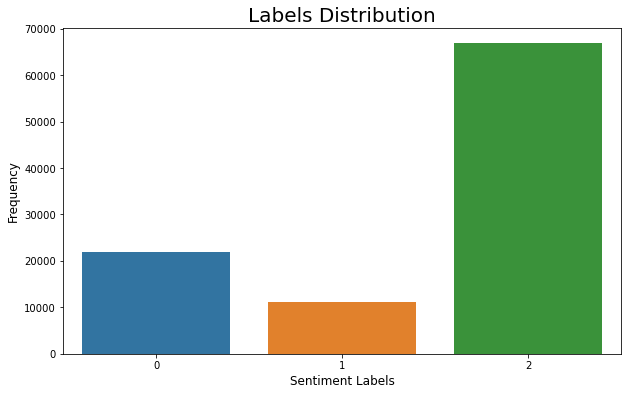

In [66]:
# Check the distribution of review labels
label_count = df_reviews["Review_Labels"].value_counts()
label_count = label_count.sort_index()

fig1 = plt.figure(figsize=(10, 6))
ax = sns.barplot(label_count.index, label_count.values)
plt.title("Labels Distribution", fontsize=20)
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Sentiment Labels", fontsize=12)

#### Text Processing, Stop Words Removal, Porter Stemming

In [67]:
# Set stopwords
stop_words = set(stopwords.words("english"))
# Stemming
ps = PorterStemmer()

In [68]:
# Define list of punctuation
punc = list(punctuation)
clean = []
for text in df_reviews["text"]:
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    # Keep letters only, and convet texts to lower case
    text = re.sub("[^a-z\s]", "", text.lower())
    # Remove punctuations
    text_nopunc = [char for char in text if char not in punc]
    text_nopunc = "".join(text_nopunc)
    wd = []
    for word in text_nopunc.split():
        word = ps.stem(word)
        if word not in stop_words:
            wd.append(word)
    clean.append(" ".join(wd))

In [69]:
df_reviews["cleaned"] = clean
print('before drop empty', df_reviews.shape)
# delete raw reviews
del df_reviews['text']
# drop empty ones
df_reviews = df_reviews[df_reviews['cleaned']!='']
print('after drop empty',df_reviews.shape)

before drop empty (100000, 4)
after drop empty (99999, 3)


In [70]:
df_reviews.to_csv(
    ENGLISH_YELP_REVIEW_PATH,
    index=False,
    header=True,
)
print('all preprocessed english reviews are stored at {}'.format(ENGLISH_YELP_REVIEW_PATH))

all preprocessed english reviews are stored at ../data/english_yep_reviews.csv


In [71]:
df_reviews.head()

,stars,Review_Labels,cleaned
0,2.0,0,someon ha work mani museum wa eager visit thi ...
1,1.0,0,actual horrifi thi place still busi year old s...
2,5.0,2,love deagan realli atmospher cozi festiv shrim...
3,1.0,0,dismal lukewarm defrostedtast texmex glop mumb...
4,4.0,2,oh happi day final cane near casa ye gripe dri...


### Vectorization with word2vec

In [72]:
print('start training w2v model ...')
start_time = time.time()
w2v_model = Word2Vec(min_count=1, window=5, size=WORD2VEC_DIMENSION,workers=4)
w2v_model.build_vocab(df_reviews["cleaned"].map(lambda x:x.split()))
w2v_model.train(df_reviews["cleaned"], total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)
w2v_model.save(WORD2VEC_MODEL_PATH)
end_time = time.time()
print('trainging finished with time {}'.format(end_time-start_time))
print('word2vec vectorized reviews saved at {}'.format(WORD2VEC_MODEL_PATH))

start training w2v model ...


<ipython-input-72-e79ca7926056>:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  w2v_model.train(df_reviews["cleaned"], total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)


trainging finished with time 52.24490475654602
word2vec vectorized reviews saved at ../data/word2vec_model


In [73]:
model = Word2Vec.load(WORD2VEC_MODEL_PATH)
print('test word2vec model:')
temp = model.wv.similarity(u'ask',u'tell')
print("similarity between 'ask' and 'tell': ", temp)

test word2vec model:
similarity between 'ask' and 'tell':  0.093848065


In [74]:
# checking word2vec vocabulary
# model.wv.vocab

In [75]:
# adding w2v vectorization to dataframe
df_reviews['w2v'] = df_reviews["cleaned"].map(lambda x:sum([model.wv[i] for i in x.split() if i in model.wv]).tolist())
df_reviews.to_csv(
    YELP_REVIEW_W2V_PATH,
    index=False,
    header=True,
)
print('vectorized w2v reviews are stored at {}'.format(YELP_REVIEW_W2V_PATH))
df_reviews.head()

vectorized w2v reviews are stored at ../data/w2v_yelp.csv


,stars,Review_Labels,cleaned,w2v
0,2.0,0,someon ha work mani museum wa eager visit thi ...,"[-0.7833308577537537, -0.6459603905677795, 1.5..."
1,1.0,0,actual horrifi thi place still busi year old s...,"[2.3488664627075195, 0.18374943733215332, 1.44..."
2,5.0,2,love deagan realli atmospher cozi festiv shrim...,"[0.10850790143013, 0.16999416053295135, 0.9217..."
3,1.0,0,dismal lukewarm defrostedtast texmex glop mumb...,"[-0.7600313425064087, -0.5083361864089966, 0.9..."
4,4.0,2,oh happi day final cane near casa ye gripe dri...,"[0.5988718867301941, 0.927848756313324, 0.2136..."


In [76]:
print('all finished')

all finished


In [78]:
# read in codes
# df_reviews = pd.read_csv(YELP_REVIEW_W2V_PATH)
# df_reviews['w2v'] = df_reviews['w2v'].map(lambda x:np.array(eval(x)))

array([-7.83330858e-01, -6.45960391e-01,  1.55615175e+00, -1.28618717e+00,
       -2.32671046e+00, -1.13509762e+00, -1.24585390e+00,  3.56679633e-02,
        1.62993813e+00,  6.17418826e-01,  3.45009506e-01, -9.01842356e-01,
       -1.57255292e+00,  4.46471199e-03,  8.54291171e-02,  6.60185739e-02,
        6.19853497e-01,  8.04456592e-01,  1.05995081e-01,  7.21373633e-02,
        1.17341065e+00, -1.85576415e+00,  7.47265995e-01,  1.74596453e+00,
        2.34829649e-01,  1.57097101e-01, -4.02461708e-01, -2.88854688e-01,
        6.99117929e-02, -9.40365255e-01,  3.22987258e-01, -7.47992873e-01,
       -2.66565323e-01,  8.86490643e-01, -1.43281031e+00, -4.95281368e-02,
        1.86685205e-01,  1.18910253e+00, -1.87144637e-01, -4.46183085e-01,
        7.80724645e-01, -3.06141555e-01, -1.08195591e+00,  4.54108775e-01,
        1.08060884e+00,  1.83364999e+00, -1.18975365e+00, -1.34546566e+00,
       -6.86629593e-01, -6.50981903e-01,  4.48218524e-01,  1.19541660e-01,
        1.76656723e+00,  